In [1]:
from collections import defaultdict
import operator
import os
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pecanpy as pp
import scipy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_geometric.nn as gnn
from umap import UMAP

In [2]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [3]:
# Data params
directed = False
disease_type = 'SCZ'
def get_dirs(disease_type):
    model_dir = f'./models/{disease_type}'
    results_dir = f'./results/{disease_type}'
    return model_dir, results_dir
model_dir, results_dir = get_dirs(disease_type)

# Run params

runs = 10  # Number of runs

folds = 3  # Folds per run

run, fold = 0, 0  # Current stat

# Dataset

In [4]:
def get_data(cell_fname, method=None, directed=False, output='_elist.edg'):
    if directed:
        # Read data
        tftg = pd.read_csv(f'./data/directed/{disease_type}/{cell_fname}', sep='\t')
        # Turn all edge weights positive (asdf, better way?)
        directed['coef'] = np.abs(directed['coef'])
        # Remove all zero weights
        tftg = tftg.iloc[np.argwhere(tftg['coef'].to_numpy() != 0).flatten(), :]
        # Save file
        tftg[['TF', 'TG', 'coef']].to_csv(output, sep='\t', header=None, index=None)
    else:
        # Read data
        tftg = pd.read_csv(f'./data/psychAD_merged_GRN_0.2_0.2/{disease_type}/{cell_fname}', sep='\t')
        # Filter to one method (SCENIC, scGRNom)
        if method is not None:
            tftg = tftg.iloc[np.argwhere((tftg['method']==method).to_numpy()).flatten(), :]
        # Remove all zero weights
        tftg = tftg.iloc[np.argwhere(tftg['edgeWeight'].to_numpy() != 0).flatten(), :]
        # Set all nonzero weights to one
        if method is None:
            tftg[['edgeWeight']] = 1.
        # Make undirected
        tg_genes = np.unique(tftg['TG'])
        tftg = pd.DataFrame(
            np.concatenate([tftg[['TF', 'TG', 'edgeWeight']].to_numpy(), tftg[['TG', 'TF', 'edgeWeight']].to_numpy()]))
        # Save file
        tftg.to_csv(output, sep='\t', header=None, index=None)
        return tg_genes

def get_labels(genes, disease_type, gene_filter=[]):
    # Get labels
    disDict = {'AD': 'Alzheimer', 'SCZ': 'Schizophrenia'}
    meta = pd.read_csv(f'./data/training_labels_NPS_disgenet_manual/{disDict[disease_type]}.disgenenet_manual.txt', index_col=None, sep='\t')
    positive_genes = meta.to_numpy().flatten()
    labels = np.array([('pos' if (g in positive_genes) else 'neg') if (g in gene_filter) else 'unk' for g in genes])

    return labels

In [5]:
if directed:
    cell_fnames = np.array(os.listdir(f'./data/directed/{disease_type}'))
else:
    cell_fnames = np.array(os.listdir(f'./data/psychAD_merged_GRN_0.2_0.2/{disease_type}'))
cell_types = [ct.split('.')[0] for ct in cell_fnames]
cell_fname = cell_fnames[0]
cell_type = cell_fname.split('.')[0]
for ct in cell_fnames:
    ct_str = ct.split('.')[0]
    print(ct_str) if ct_str != cell_type else print(f'--{ct_str}')

--Astrocyte
Endothelial
GABAergic neuron
GABAergic PVALB interneuron
GABAergic SST interneuron
GABAergic VIP interneuron
Glutamatergic neuron
Microglia
Mural
Oligodendrocyte
OPC


Generating Astrocyte graph...
Filtering data...


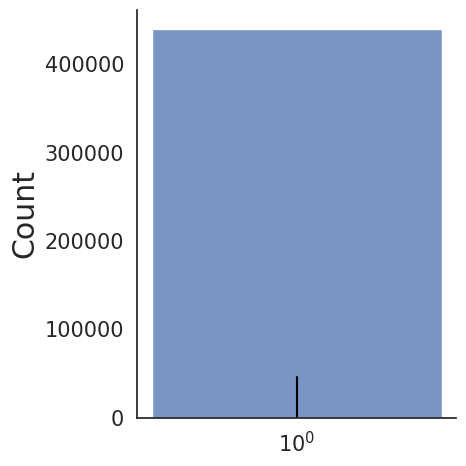

In [6]:
print(f'Generating {cell_type} graph...')
# Load data
tg_genes = get_data(cell_fname, directed=directed)

# Plot approximate distribution
elist = pd.read_csv('_elist.edg', sep='\t', header=None)
# np.random.seed(42)
# sns.displot(np.random.choice(elist.iloc[:, 2].to_numpy().flatten(), 1000))
sns.displot(elist.iloc[:, 2].to_numpy().flatten(), log_scale=True)

# Eliminate low-value data
print(f'Filtering data...')
percentile = 0
reg_threshold = np.percentile(elist.iloc[:, 2].to_numpy().flatten(), percentile)
elist = elist.iloc[np.argwhere((elist.iloc[:, 2] >= reg_threshold).to_numpy()).flatten(), :]
elist.to_csv('_elist.edg', sep='\t', header=None, index=None)
plt.axvline(reg_threshold, ymax=.1, color='black');

# Pipeline

## Node2Vec+

In [7]:
print('Reading graph...')
# Load as precomp
g = pp.pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=False, random_state=42+run)
g.read_edg('_elist.edg', weighted=True, directed=directed)
# g.preprocess_transition_probs()

Reading graph...


In [8]:
dim, num_walks, walk_length = 64, 20, 80
fname = f'{model_dir}/embeddings-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}.npy'
if os.path.exists(fname):
    print('Loading embeddings...')
    # Load embeddings
    emb_pp = np.load(fname)
else:
    print('Generating embeddings...')
    # Generate embeddings
    emb_pp = g.embed(dim=dim, num_walks=num_walks, walk_length=walk_length)
    np.save(fname, emb_pp)

# Chart connected subgraph
# surviving_nodes = [np.argwhere(genes==gn).flatten()[0] for gn in g.nodes]
genes = g.nodes
labels = get_labels(genes, disease_type, gene_filter=tg_genes)

Loading embeddings...


## Prediction

In [9]:
# Load dataset
elist = np.loadtxt('_elist.edg', dtype=str)
gene_to_index = {g: i for g, i in zip(genes, range(len(genes)))}
edge_index = np.array([[gene_to_index[f] for f in e[:2]] for e in elist]).T
edge_weight = np.array([float(e[2]) for e in elist])

# Add embeddings and labels
x = emb_pp
y = np.array([{'pos': 1, 'neg': 0, 'unk': 2}[l] for l in labels])

# Split data
np.random.seed(42 + run)
unk_idx = np.argwhere(y==2).flatten()
unk_mask = np.zeros(x.shape[0], dtype=bool)
unk_mask[unk_idx] = True
groups = np.random.choice(folds, x.shape[0])
train_idx = np.argwhere(groups!=fold).flatten()
train_idx = np.array(list(set(train_idx) - set(unk_idx)))
train_mask = np.zeros(x.shape[0], dtype=bool)
train_mask[train_idx] = True
val_idx = np.array(list(set(list(range(x.shape[0]))) - set(train_idx)))
val_idx = np.array(list(set(val_idx) - set(unk_idx)))
val_mask = np.zeros(x.shape[0], dtype=bool)
val_mask[val_idx] = True

# Create dataset
dataset = tg.data.Data(
    x=torch.tensor(x).float(),
    edge_index=torch.tensor(edge_index, dtype=int),
    edge_weight=torch.tensor(edge_weight).float(),
    y=torch.tensor(y, dtype=int),
    train_mask=torch.tensor(train_mask),
    val_mask=torch.tensor(val_mask),
    unk_mask=torch.tensor(unk_mask))
assert dataset.is_directed() == directed
dataset

Data(x=[5999, 64], edge_index=[2, 439596], y=[5999], edge_weight=[439596], train_mask=[5999], val_mask=[5999], unk_mask=[5999])

### GCN

In [10]:
# class GCN(torch.nn.Module):
#     def __init__(self, input_size=dim):
#         super().__init__()
#         self.encode = gnn.Sequential('x, edge_index, edge_weight', [
#             (nn.Linear(input_size, 2*input_size), 'x -> x'),
#             # (gnn.GCNConv(32, 64), 'x, edge_index, edge_weight -> x'),
#             # (nn.LeakyReLU(), 'x -> x'),
#             (gnn.GCNConv(2*input_size, input_size), 'x, edge_index, edge_weight -> x'),
#             (nn.LeakyReLU(), 'x -> x'),
#             (gnn.GCNConv(input_size, int(input_size/2)), 'x, edge_index, edge_weight -> x'),
#             (nn.LeakyReLU(), 'x -> x'),
#         ])
#         self.decode = gnn.Sequential('x, edge_index, edge_weight', [
#             (nn.Linear(int(input_size/2), 2), 'x -> x'),
#             # (gnn.GCNConv(16, 2), 'x, edge_index, edge_weight -> x'),
#             (nn.LogSoftmax(dim=-1), 'x -> x'),
#         ])

#     def forward(self, data):
#         x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
#         return self.decode(self.encode(x, edge_index, edge_weight), edge_index, edge_weight)
# model_str = 'gcn'
# model_class = GCN

### MLP

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, input_size=dim):
        super().__init__()
        self.encode = nn.Sequential(
            # nn.Dropout(.6),
            
            nn.Linear(input_size, 2*input_size),
            nn.Dropout(.6),
            nn.BatchNorm1d(2*input_size),
            nn.LeakyReLU(),
            
            nn.Linear(2*input_size, input_size),
            nn.Dropout(.6),
            nn.BatchNorm1d(input_size),
            nn.LeakyReLU(),
            
            nn.Linear(input_size, int(input_size/2)),
            nn.Dropout(.6),
            nn.BatchNorm1d(int(input_size/2)),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(int(input_size/2), 2),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        return self.decode(self.encode(x))
model_str = 'mlp'
model_class = MLP

### Training

In [12]:
torch.manual_seed(42 + run*folds + fold)
np.random.seed(42 + run*folds + fold)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_class().to(device)
data = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
fname = f'{model_dir}/{model_str}-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}-{fold}_{folds}.h5'

model.train()
if os.path.exists(fname):
    model.load_state_dict(torch.load(fname))
else:
    max_lapses = 50; min_improvement = .01
    min_loss = np.inf; lapses = 0
    for epoch in range(10_001):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if loss < min_loss - min_improvement:
            min_loss = loss.detach()
            lapses = 0
        else:
            lapses += 1
        if lapses >= max_lapses:
            print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
            break
        if epoch % 100 == 0:
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
    torch.save(model.state_dict(), fname)
model.eval();

Epoch 0
Train Loss: 0.7992
Valid Loss: 0.8031
Epoch 100
Train Loss: 0.5591
Valid Loss: 0.5492
Epoch 200
Train Loss: 0.4358
Valid Loss: 0.4422
Epoch 300
Train Loss: 0.3476
Valid Loss: 0.3501
Epoch 400
Train Loss: 0.2893
Valid Loss: 0.2860
Epoch 500
Train Loss: 0.2401
Valid Loss: 0.2355
Epoch 600
Train Loss: 0.2010
Valid Loss: 0.2033
Epoch 700
Train Loss: 0.1760
Valid Loss: 0.1739
Epoch 800
Train Loss: 0.1563
Valid Loss: 0.1528
Epoch 826
Train Loss: 0.1488
Valid Loss: 0.1528


In [13]:
pred_raw = model(data).detach()
pred = pred_raw.argmax(dim=1)
threshold = pred_raw[data.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))

print('Evaluating performance...')
print('Train')
## Train
# Perform prediction
logits = pred_raw[:, 1][data.train_mask]
trans = {'pos': 1, 'neg': 0, 'unk': 2}
trans_inv = {v: k for k, v in trans.items()}
true = torch.Tensor([trans[l] for l in labels[data.train_mask]]).long()

# Get confusion
conf = confusion_matrix(true, 1*(logits > threshold))
# conf = confusion_matrix(true, pred)
print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv)-1)]))
for i, row in enumerate(conf):
    print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# Other statistics
fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUROC:\t{auc(fpr, tpr):.4f}')
prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUPRC:\t{auc(rec, prec):.4f}')
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')
print()

print('Eval')
## Eval
# Perform prediction
logits = pred_raw[:, 1][data.val_mask]
trans = {'pos': 1, 'neg': 0, 'unk': 2}
trans_inv = {v: k for k, v in trans.items()}
true = torch.Tensor([trans[l] for l in labels[data.val_mask]]).long()

# Get confusion
conf = confusion_matrix(true, 1*(logits > threshold))
# conf = confusion_matrix(true, pred)
print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv))]))
for i, row in enumerate(conf):
    print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# Other statistics
fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUROC:\t{auc(fpr, tpr):.4f}')
prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUPRC:\t{auc(rec, prec):.4f}')
correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
acc = int(correct) / int(data.val_mask.sum())
print(f'Accuracy: {acc:.4f}')
print()

Evaluating performance...
Train
T\P	neg	pos
neg	3761	47
pos	47	1
AUROC:	0.5219
AUPRC:	0.0133
Accuracy: 0.9876

Eval
T\P	neg	pos	unk
neg	1938	41
pos	23	1
AUROC:	0.6503
AUPRC:	0.0215
Accuracy: 0.9880



## Folds

In [14]:
auroc_list = []
ad_dict = defaultdict(lambda: np.zeros(3))
for cell_fname in cell_fnames:
    cell_type = cell_fname.split('.')[0]
    print(f'---------{cell_type}')

    auroc_list.append([])
    for run in range(runs):
        print(f'------Run {run+1}')
        
        auroc_list[-1].append([])
        for fold in range(folds):
            print(f'---Fold {fold+1}', end='\t')
            
            ### Generate graph
            # print(f'Generating {cell_type} graph...')
            # Load data
            tg_genes = get_data(cell_fname, directed=directed)
            
            # Plot approximate distribution
            elist = pd.read_csv('_elist.edg', sep='\t', header=None)

            # Eliminate low-value data
            # print(f'Filtering data...')
            reg_threshold = np.percentile(elist.iloc[:, 2].to_numpy().flatten(), percentile)
            elist = elist.iloc[np.argwhere((elist.iloc[:, 2] >= reg_threshold).to_numpy()).flatten(), :]
            elist.to_csv('_elist.edg', sep='\t', header=None, index=None)

            ### Read graph
            # print('Reading graph...')
            # Load as precomp
            g = pp.pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=False, random_state=42+run)
            g.read_edg('_elist.edg', weighted=True, directed=directed)
            # g.preprocess_transition_probs()

            ### Generate embeddings
            fname = f'{model_dir}/embeddings-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}.npy'
            if os.path.exists(fname):
                # print('Loading embeddings...')
                # Load embeddings
                emb_pp = np.load(fname)
            else:
                # print('Generating embeddings...')
                # Generate embeddings
                emb_pp = g.embed(dim=dim, num_walks=num_walks, walk_length=walk_length)
                np.save(fname, emb_pp)

            # Chart connected subgraph
            # surviving_nodes = [np.argwhere(genes==gn).flatten()[0] for gn in g.nodes]
            genes = g.nodes
            labels = get_labels(genes, disease_type, gene_filter=tg_genes)

            ### Make dataset
            # Load dataset
            elist = np.loadtxt('_elist.edg', dtype=str)
            gene_to_index = {g: i for g, i in zip(genes, range(len(genes)))}
            edge_index = np.array([[gene_to_index[f] for f in e[:2]] for e in elist]).T
            edge_weight = np.array([float(e[2]) for e in elist])

            # Add embeddings and labels
            x = emb_pp
            y = np.array([{'pos': 1, 'neg': 0, 'unk': 2}[l] for l in labels])

            # Split data
            np.random.seed(42 + run)
            unk_idx = np.argwhere(y==2).flatten()
            unk_mask = np.zeros(x.shape[0], dtype=bool)
            unk_mask[unk_idx] = True
            groups = np.random.choice(folds, x.shape[0])
            train_idx = np.argwhere(groups!=fold).flatten()
            train_idx = np.array(list(set(train_idx) - set(unk_idx)))
            train_mask = np.zeros(x.shape[0], dtype=bool)
            train_mask[train_idx] = True
            val_idx = np.array(list(set(list(range(x.shape[0]))) - set(train_idx)))
            val_idx = np.array(list(set(val_idx) - set(unk_idx)))
            val_mask = np.zeros(x.shape[0], dtype=bool)
            val_mask[val_idx] = True

            # Create dataset
            dataset = tg.data.Data(
                x=torch.tensor(x).float(),
                edge_index=torch.tensor(edge_index, dtype=int),
                edge_weight=torch.tensor(edge_weight).float(),
                y=torch.tensor(y, dtype=int),
                train_mask=torch.tensor(train_mask),
                val_mask=torch.tensor(val_mask),
                unk_mask=torch.tensor(unk_mask))
            assert dataset.is_directed() == directed
            dataset

            ### Train model
            torch.manual_seed(42 + run*folds + fold)
            np.random.seed(42 + run*folds + fold)

            # Train model
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model_class().to(device)
            data = dataset.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
            fname = f'{model_dir}/{model_str}-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}-{fold}.h5'

            model.train()
            if os.path.exists(fname):
                model.load_state_dict(torch.load(fname))
            else:
                max_lapses = 50; min_improvement = .01
                min_loss = np.inf; lapses = 0
                for epoch in range(10_001):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
                    loss.backward()
                    optimizer.step()
                    if loss < min_loss - min_improvement:
                        min_loss = loss.detach()
                        lapses = 0
                    else:
                        lapses += 1
                    if lapses >= max_lapses:
                        # print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
                        break
                    # if epoch % 100 == 0:
                    #     val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
                    #     print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
                torch.save(model.state_dict(), fname)
            model.eval()

            ### Evaluate performance
            pred_raw = model(data).detach()
            pred = pred_raw.argmax(dim=1)
            threshold = pred_raw[data.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))

            # print('Evaluating performance...')
            # print('Train')
            ## Train
            # Perform prediction
            logits = pred_raw[:, 1][data.train_mask]
            trans = {'pos': 1, 'neg': 0, 'unk': 2}
            trans_inv = {v: k for k, v in trans.items()}
            true = torch.Tensor([trans[l] for l in labels[data.train_mask]]).long()

            # Get confusion
            # conf = confusion_matrix(true, 1*(logits > threshold))
            # # conf = confusion_matrix(true, pred)
            # print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv)-1)]))
            # for i, row in enumerate(conf):
            #     print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

            # # Other statistics
            # fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
            # print(f'AUROC:\t{auc(fpr, tpr):.4f}')
            # prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
            # print(f'AUPRC:\t{auc(rec, prec):.4f}')
            # correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
            # acc = int(correct) / int(data.train_mask.sum())
            # print(f'Accuracy: {acc:.4f}')
            # print()

            # print('Eval')
            ## Eval
            # Perform prediction
            logits = pred_raw[:, 1][data.val_mask]
            trans = {'pos': 1, 'neg': 0, 'unk': 2}
            trans_inv = {v: k for k, v in trans.items()}
            true = torch.Tensor([trans[l] for l in labels[data.val_mask]]).long()

            # Get confusion
            conf = confusion_matrix(true, 1*(logits > threshold))
            # conf = confusion_matrix(true, pred)
            # print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv))]))
            # for i, row in enumerate(conf):
            #     print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

            # Other statistics
            fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
            print(f'AUROC:\t{auc(fpr, tpr):.4f}')
            # prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
            # print(f'AUPRC:\t{auc(rec, prec):.4f}')
            # correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
            # acc = int(correct) / int(data.val_mask.sum())
            # print(f'Accuracy: {acc:.4f}')
            # print()

            # Save predictions
            fname = f'{results_dir}/{model_str}-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}-{fold}_{folds}-Predictions.txt'
            np.savetxt(fname, np.array([[g, float(p)] for g, p in zip(genes, pred_raw[:, 1])]), fmt='%s %s')

            # Add to lists
            auroc = auc(fpr, tpr)
            auroc_list[-1][-1].append(auroc)
            for i, g in enumerate(genes):
                if (data.unk_mask[i] or data.val_mask[i]) and auroc > .5:
                    ad_dict[g] += np.array([auroc**2 * np.exp(float(pred_raw[i, 1])), auroc**2, 1])

---------Astrocyte
------Run 1
---Fold 1	AUROC:	0.6232
---Fold 2	AUROC:	0.6011
---Fold 3	AUROC:	0.5717
------Run 2
---Fold 1	AUROC:	0.6396
---Fold 2	AUROC:	0.6133
---Fold 3	AUROC:	0.4657
------Run 3
---Fold 1	AUROC:	0.5689
---Fold 2	AUROC:	0.6744
---Fold 3	AUROC:	0.6055
------Run 4
---Fold 1	AUROC:	0.6413
---Fold 2	AUROC:	0.4546
---Fold 3	AUROC:	0.6023
------Run 5
---Fold 1	AUROC:	0.6526
---Fold 2	AUROC:	0.5397
---Fold 3	AUROC:	0.5357
------Run 6
---Fold 1	AUROC:	0.5999
---Fold 2	AUROC:	0.5374
---Fold 3	AUROC:	0.5410
------Run 7
---Fold 1	AUROC:	0.5824
---Fold 2	AUROC:	0.5092
---Fold 3	AUROC:	0.6493
------Run 8
---Fold 1	AUROC:	0.5641
---Fold 2	AUROC:	0.5361
---Fold 3	AUROC:	0.6077
------Run 9
---Fold 1	AUROC:	0.6379
---Fold 2	AUROC:	0.5612
---Fold 3	AUROC:	0.6387
------Run 10
---Fold 1	AUROC:	0.6586
---Fold 2	AUROC:	0.6479
---Fold 3	AUROC:	0.6219
---------Endothelial
------Run 1
---Fold 1	AUROC:	0.6274
---Fold 2	AUROC:	0.4116
---Fold 3	AUROC:	0.5484
------Run 2
---Fold 1	AUROC:	0.5470

### Results

In [15]:
# Set colors
sns.set_palette('husl', 3)

In [16]:
# Save performance
np.save(f'{results_dir}/auroc-{runs}-{folds}.npy', auroc_list)

# Get common AD
# Use only if number of occurrences > # of folds per cell type
weighted_ad = {k: v[0] / v[1] for k, v in ad_dict.items() if v[2] > folds}
sorted_ad = sorted(weighted_ad.items(), key=operator.itemgetter(1))[::-1]
fname = f'{results_dir}/{model_str}-{dim}-{num_walks}-{walk_length}-{percentile}-Predictions.txt'
np.savetxt(fname, np.array(sorted_ad), fmt='%s %s')

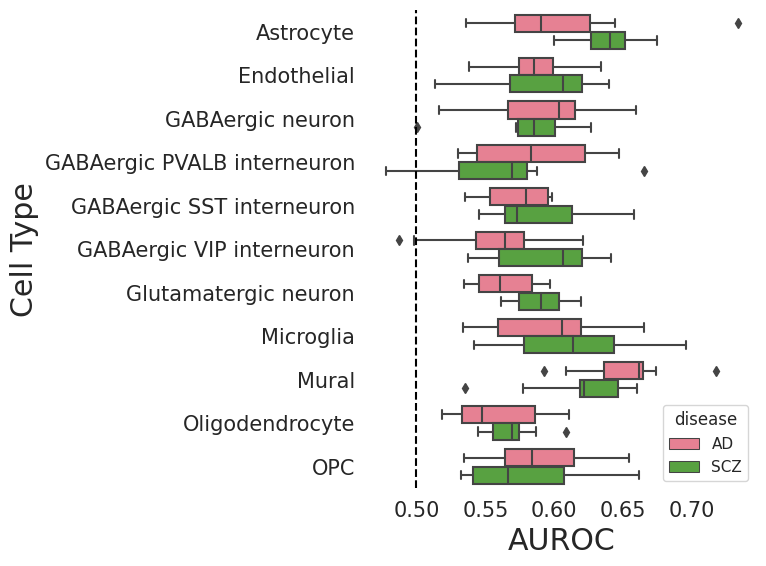

In [17]:
# Load performances
diseases = ['AD', 'SCZ']
auroc_lists = [np.load(f'{get_dirs(d)[1]}/auroc-{runs}-{folds}.npy') for d in diseases]
# Convert to pandas df
df = pd.DataFrame(data={
    'disease': np.concatenate([runs*len(cell_types)*[d] for d in diseases]),
    'cell_type': np.concatenate(len(diseases)*[runs*[ct] for ct in cell_types]),
    'run': np.concatenate(len(diseases)*[list(range(runs)) for i in cell_types]),
    'auroc': np.concatenate([np.concatenate(np.array(al).max(axis=-1)) for al in auroc_lists]),
})
# Style
# style = {
#     'boxprops':{'facecolor':'none', 'edgecolor':'black'},
#     'medianprops':{'color':'black'},
#     'whiskerprops':{'color':'black'},
#     'capprops':{'color':'black'}}
style = {}

fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
axs = [axs]
# Barplot
sns.boxplot(ax=axs[0], data=df, x='auroc', y='cell_type', hue='disease', **style)
sns.despine(ax=axs[0], left=True, bottom=True)
# sns.boxplot(ax=axs[1], data=df, x='auprc', y='cell_type', **style)
# sns.despine(ax=axs[1], left=False, bottom=True)
# Labels
axs[0].set_xlabel('AUROC')
axs[0].set_ylabel('Cell Type')
axs[0].axvline(x=.5, color='black', linestyle='--')
# axs[1].set_xlabel('AUPRC')
# axs[1].set_ylabel(None)
plt.tight_layout()
# Save figure
plt.savefig(f'{get_dirs("")[1][:-1]}/fig_performance-{runs}-{folds}.png', dpi=300, bbox_inches='tight')

# Visualization

In [18]:
name_map = {'pos': 'Disease', 'neg': 'Not Disease', 'unk': 'Unknown'}
color_map = {'pos': np.array((1, .2, .2)), 'neg': np.array((.2, .2, 1)), 'unk': np.array((0, 0, 0))}
z_map = {'pos': 2, 'neg': 1, 'unk': 0}
s_map = {'pos': 10., 'neg': 1., 'unk': .5}

In [19]:
%%capture
from matplotlib.lines import Line2D

# Legend
legend = [
    Line2D([], [], color=(1, 1, 1, 0), markerfacecolor=color_map[l], marker='o', markersize=10)
    for l in name_map]
legend_names = [name_map[l] for l in name_map]

# Plot legend
fig, ax = plt.subplots()
legend = ax.legend(legend, legend_names, loc='center', frameon=False, ncol=len(legend)//1)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{results_dir}/fig_legend.png', bbox_inches=bbox, dpi=300)

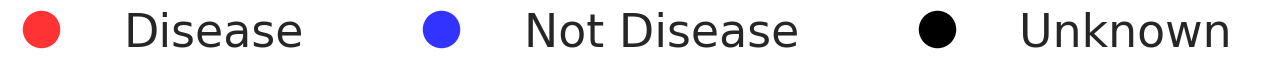

In [20]:
from IPython.display import display, Image
display( Image(filename=f'{results_dir}/fig_legend.png', width=800) )

In [21]:
### Get best model
auroc_list = np.load(f'{results_dir}/auroc-{runs}-{folds}.npy')
ct, run, fold = np.unravel_index(np.argmax(auroc_list), auroc_list.shape)
cell_type, cell_fname = cell_types[ct], cell_fnames[ct]

### Load best model
# Load data
tg_genes = get_data(cell_fname, directed=directed)
# Plot approximate distribution
elist = pd.read_csv('_elist.edg', sep='\t', header=None)
# Eliminate low-value data
reg_threshold = np.percentile(elist.iloc[:, 2].to_numpy().flatten(), percentile)
elist = elist.iloc[np.argwhere((elist.iloc[:, 2] >= reg_threshold).to_numpy()).flatten(), :]
elist.to_csv('_elist.edg', sep='\t', header=None, index=None)
# Read graph
g = pp.pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=False, random_state=42+run)
g.read_edg('_elist.edg', weighted=True, directed=directed)
# Generate embeddings
fname = f'{model_dir}/embeddings-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}.npy'
emb_pp = np.load(fname)
# Chart connected subgraph
genes = g.nodes
labels = get_labels(genes, disease_type, gene_filter=tg_genes)
# Make dataset
elist = np.loadtxt('_elist.edg', dtype=str)
gene_to_index = {g: i for g, i in zip(genes, range(len(genes)))}
edge_index = np.array([[gene_to_index[f] for f in e[:2]] for e in elist]).T
edge_weight = np.array([float(e[2]) for e in elist])
# Add embeddings and labels
x = emb_pp
y = np.array([{'pos': 1, 'neg': 0, 'unk': 2}[l] for l in labels])
# Split data
np.random.seed(42 + run)
unk_idx = np.argwhere(y==2).flatten()
unk_mask = np.zeros(x.shape[0], dtype=bool)
unk_mask[unk_idx] = True
groups = np.random.choice(folds, x.shape[0])
train_idx = np.argwhere(groups!=fold).flatten()
train_idx = np.array(list(set(train_idx) - set(unk_idx)))
train_mask = np.zeros(x.shape[0], dtype=bool)
train_mask[train_idx] = True
val_idx = np.array(list(set(list(range(x.shape[0]))) - set(train_idx)))
val_idx = np.array(list(set(val_idx) - set(unk_idx)))
val_mask = np.zeros(x.shape[0], dtype=bool)
val_mask[val_idx] = True
# Create dataset
dataset = tg.data.Data(
    x=torch.tensor(x).float(),
    edge_index=torch.tensor(edge_index, dtype=int),
    edge_weight=torch.tensor(edge_weight).float(),
    y=torch.tensor(y, dtype=int),
    train_mask=torch.tensor(train_mask),
    val_mask=torch.tensor(val_mask),
    unk_mask=torch.tensor(unk_mask))
assert dataset.is_directed() == directed
dataset
# Train model
torch.manual_seed(42 + run*folds + fold)
np.random.seed(42 + run*folds + fold)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_class().to(device)
data = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
fname = f'{model_dir}/{model_str}-{cell_type}-{dim}-{num_walks}-{walk_length}-{percentile}-{run}-{fold}.h5'
model.load_state_dict(torch.load(fname))
model.eval()
# Evaluate performance
pred_raw = model(data).detach()
pred = pred_raw.argmax(dim=1)
threshold = pred_raw[data.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))

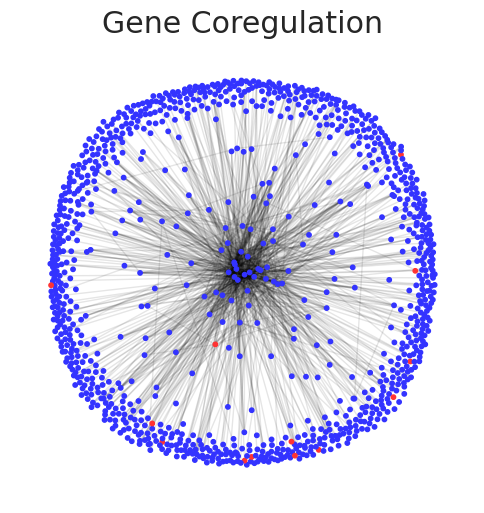

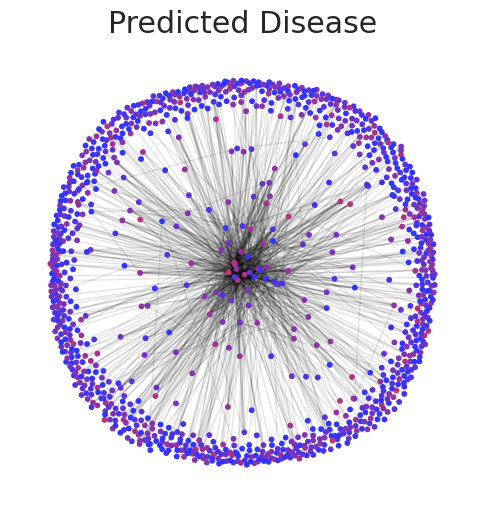

In [22]:
np.random.seed(42)
# submask = torch.tensor((np.random.rand(dataset.x.shape[0]) > .7), dtype=bool)
submask = torch.tensor((np.random.rand(dataset.x.shape[0]) > .4), dtype=bool) * dataset.val_mask
G = tg.utils.to_networkx(dataset.subgraph(np.argwhere(submask).flatten()), node_attrs=['x'], edge_attrs=['edge_weight'], to_undirected=not directed)
edge_color = [(0, 0, 0, .1*G[u][v]['edge_weight'] / float(dataset.subgraph(np.argwhere(submask).flatten()).edge_weight.max())) for u, v in G.edges]
pos = nx.spring_layout(G, weight='edge_weight', k=.5)

# Original Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
node_color = [color_map[trans_inv[int(v)]] for v in dataset.y[submask]]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Gene Coregulation')
plt.savefig(f'{results_dir}/fig_data-{runs}-{folds}.png', dpi=300)

# Computed Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# pred = model(dataset).detach().argmax(dim=1)
threshold = pred_raw[data.train_mask, 1].flatten().quantile(1 - (sum(labels=='pos') / (sum(labels=='pos') + sum(labels=='neg'))))
pred = 1*(model(dataset).detach()[:, 1] > threshold)
# Show known
# node_color = [color_map[trans_inv[int(v)]] if v != 2 else color_map[trans_inv[int(w)]] for v, w in zip(dataset.y[submask], pred[submask])]
# Do not show known
# node_color = [color_map[trans_inv[int(v)]] for v in pred[submask]]
# Show spectrum
strong_range = .1
center = .4
min_range, max_range = center - strong_range, center + strong_range
node_color = [
    np.array(
        (1-((max(min(v[1], max_range), min_range) - min_range)/(2*strong_range)))*color_map['neg']
        + ((max(min(v[1], max_range), min_range) - min_range)/(2*strong_range))*color_map['pos']
    )
        for v in pred_raw[submask].exp().numpy()]
node_color = [[max(min(cv, 1), 0) for cv in c] for c in node_color]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Predicted Disease')
plt.savefig(f'{results_dir}/fig_prediction-{runs}-{folds}.png', dpi=300)